[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-external-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)

# Chatbot with message summarization & external DB memory

## Review

We've covered how to customize graph state schema and reducer.

We've also shown a number of tricks for trimming or filtering messages in graph state.

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases.

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_groq

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database.

If we supply `":memory:"` it creates an in-memory Sqlite database.

In [3]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

But, if we supply a db path, then it will create a database for us!

In [4]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

--2025-10-17 12:06:47--  https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db [following]
--2025-10-17 12:06:47--  https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110592 (108K) [application/octet-stream]
Saving to: ‘state_db/example.db’

example.db          100%[===================>] 108.00K  --.-KB/s    in 0.05s   

2025-10-17 12:06:48 (2.13 MB/s) - 

In [5]:
# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Let's re-define our chatbot.

In [11]:
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatGroq(model="openai/gpt-oss-120b",
                api_key = os.environ.get("GROQ_API_KEY"),
                temperature = 0
)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

Now, we just re-compile with our sqlite checkpointer.

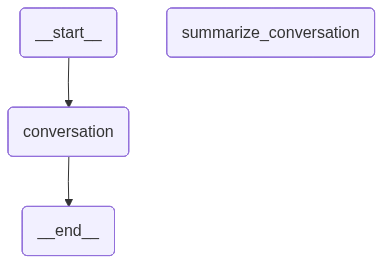

In [12]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times.

In [13]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hey there, Lance! Great to hear from you again. Since you’re a 49ers fan, is there a particular player, game, or era you’d like to dive into? Or if you’d rather chat about something completely different, just let me know—I’m happy to go wherever the conversation takes us!
================================== Ai Message ==================================

Your name is Lance. 😊

Anything specific you’d like to talk about—maybe a favorite 49ers moment or something else? Let me know!
================================== Ai Message ==================================

Got it—you're a San Francisco 49ers fan! 🏈  

Here are a few ways we could keep the conversation rolling:

1. **Current roster** – Want to talk about the latest quarterback situation, the defense, or any breakout players?  
2. **Historic moments** – Relive classic games like the 1989 “Catch” or the 1994 Super Bowl win.  
3. **Legendary players** – Joe

Let's confirm that our state is saved locally.

In [14]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='024eafc7-4bdf-41ae-87d7-a22e51b8dbe9'), AIMessage(content='Hey there, Lance! Great to hear from you again. Since you’re a 49ers fan, is there a particular player, game, or era you’d like to dive into? Or if you’d rather chat about something completely different, just let me know—I’m happy to go wherever the conversation takes us!', additional_kwargs={'reasoning_content': 'The user repeats introduction. We should respond acknowledging name, maybe ask about 49ers or new topic. Avoid repetition. Keep conversation engaging.'}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 472, 'total_tokens': 574, 'completion_time': 0.21954971, 'prompt_time': 0.089657857, 'queue_time': 0.338872689, 'total_time': 0.309207567}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_4913bcd64f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'l

### Persisting state

Using database like Sqlite means state is persisted!

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.


In [15]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='024eafc7-4bdf-41ae-87d7-a22e51b8dbe9'), AIMessage(content='Hey there, Lance! Great to hear from you again. Since you’re a 49ers fan, is there a particular player, game, or era you’d like to dive into? Or if you’d rather chat about something completely different, just let me know—I’m happy to go wherever the conversation takes us!', additional_kwargs={'reasoning_content': 'The user repeats introduction. We should respond acknowledging name, maybe ask about 49ers or new topic. Avoid repetition. Keep conversation engaging.'}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 472, 'total_tokens': 574, 'completion_time': 0.21954971, 'prompt_time': 0.089657857, 'queue_time': 0.338872689, 'total_time': 0.309207567}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_4913bcd64f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'l

## LangGraph Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

Had a general conversation:

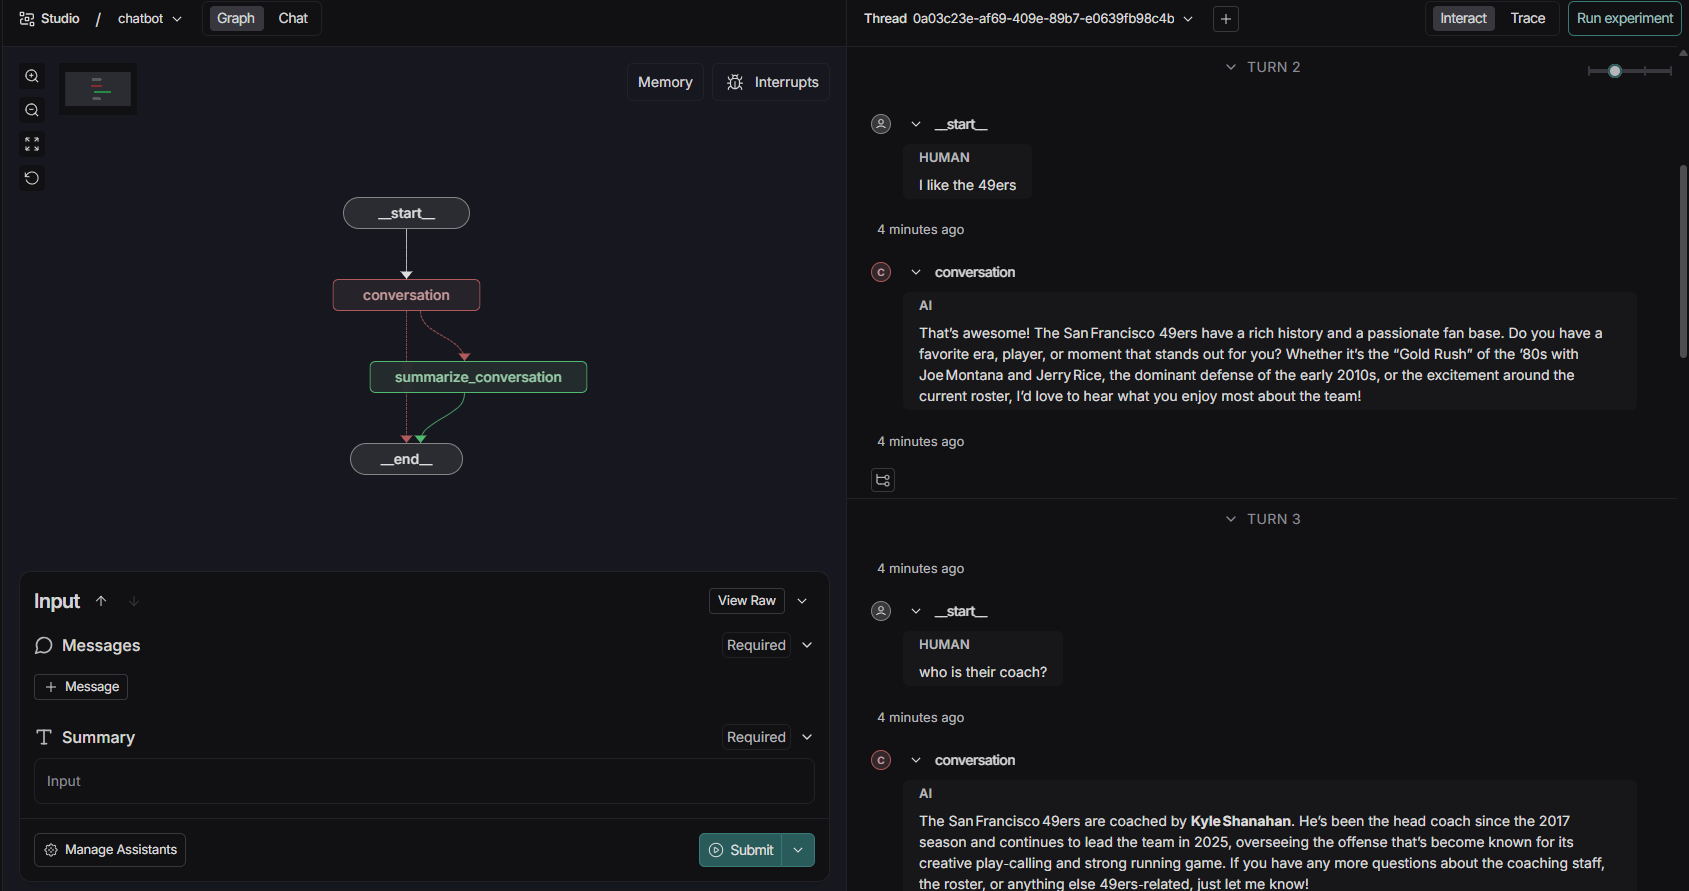

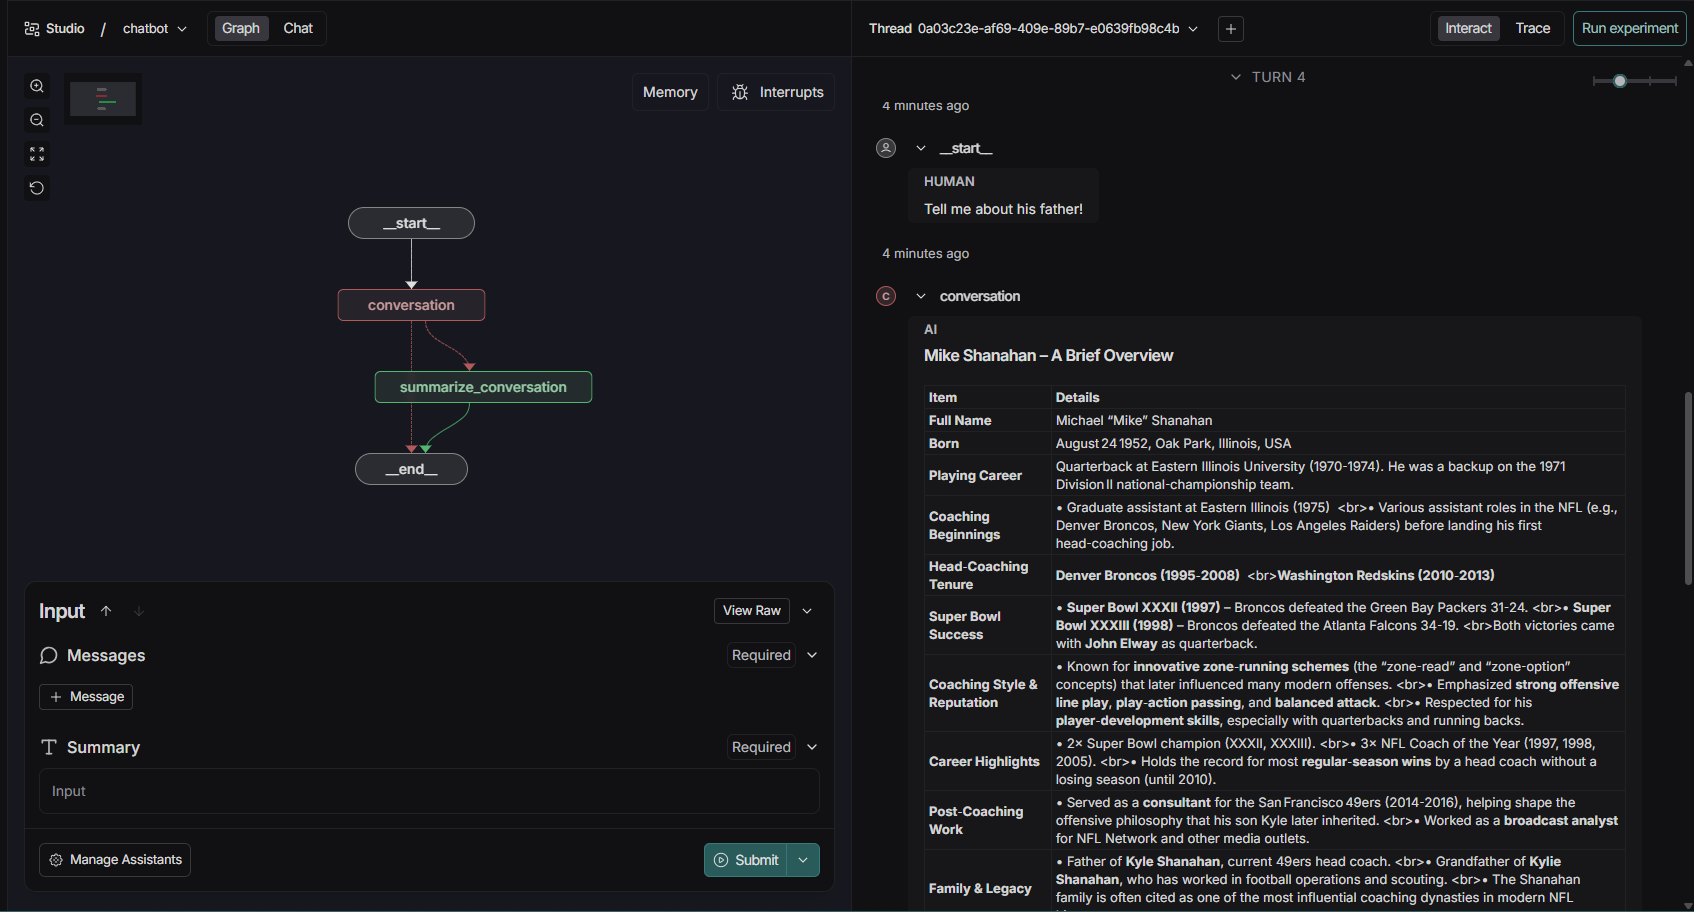

After the messages limit is hit, it starts to summarize:

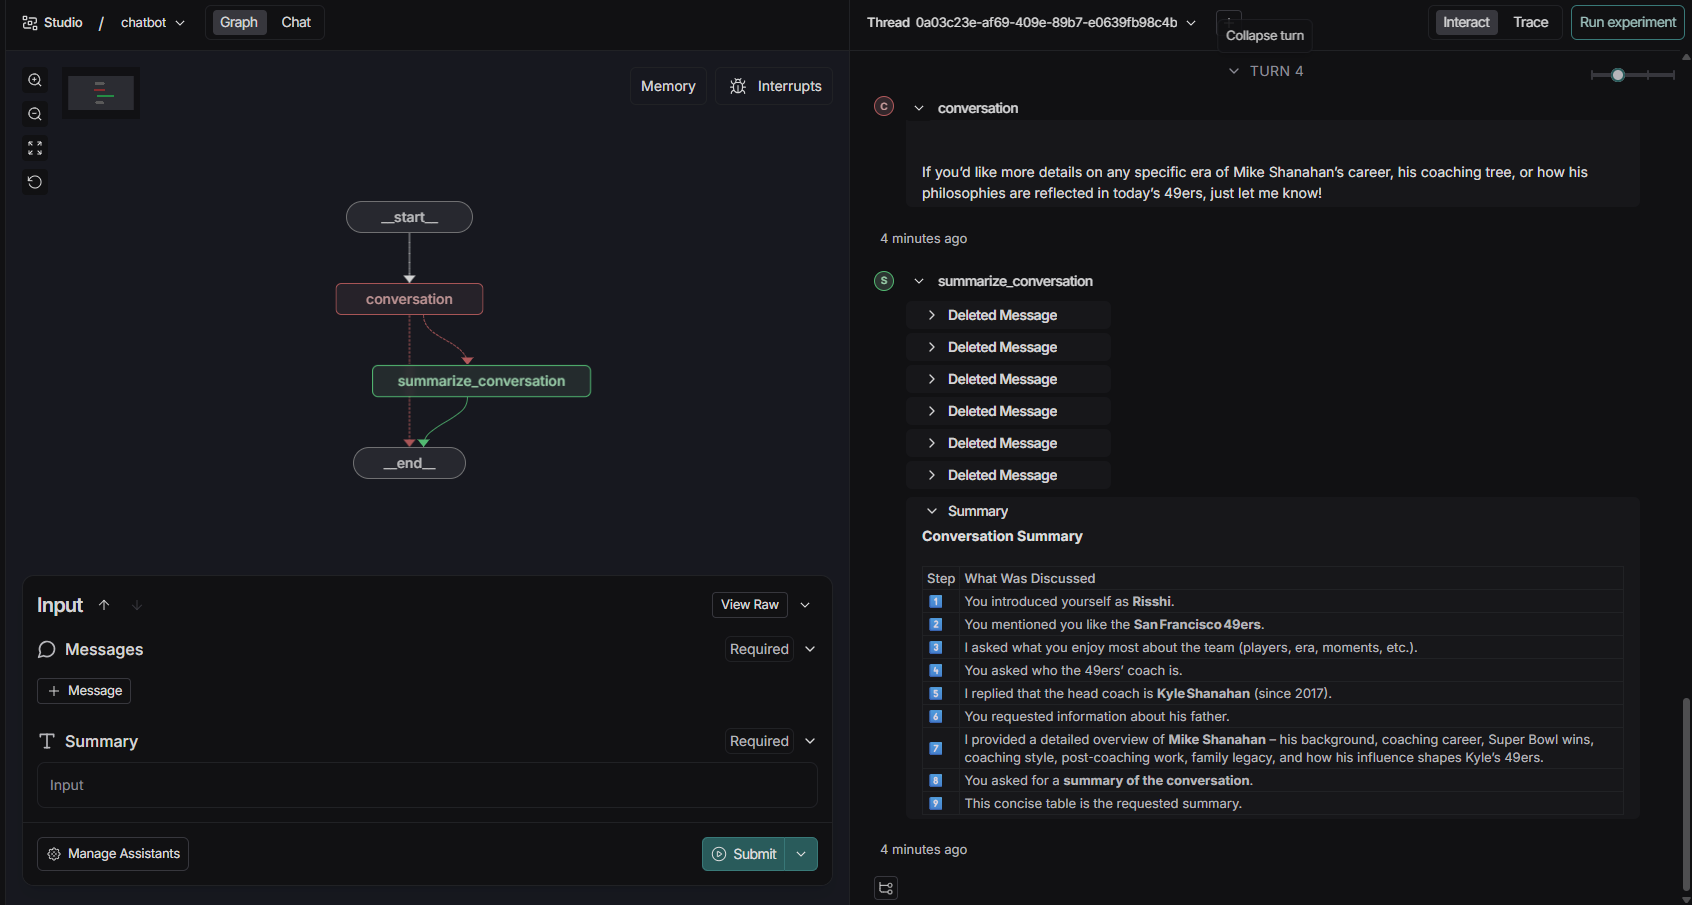

Then I started a random conversation on a new thread, then came back and i asked a related question, and as we can see, the local persistence through PostGres still works:

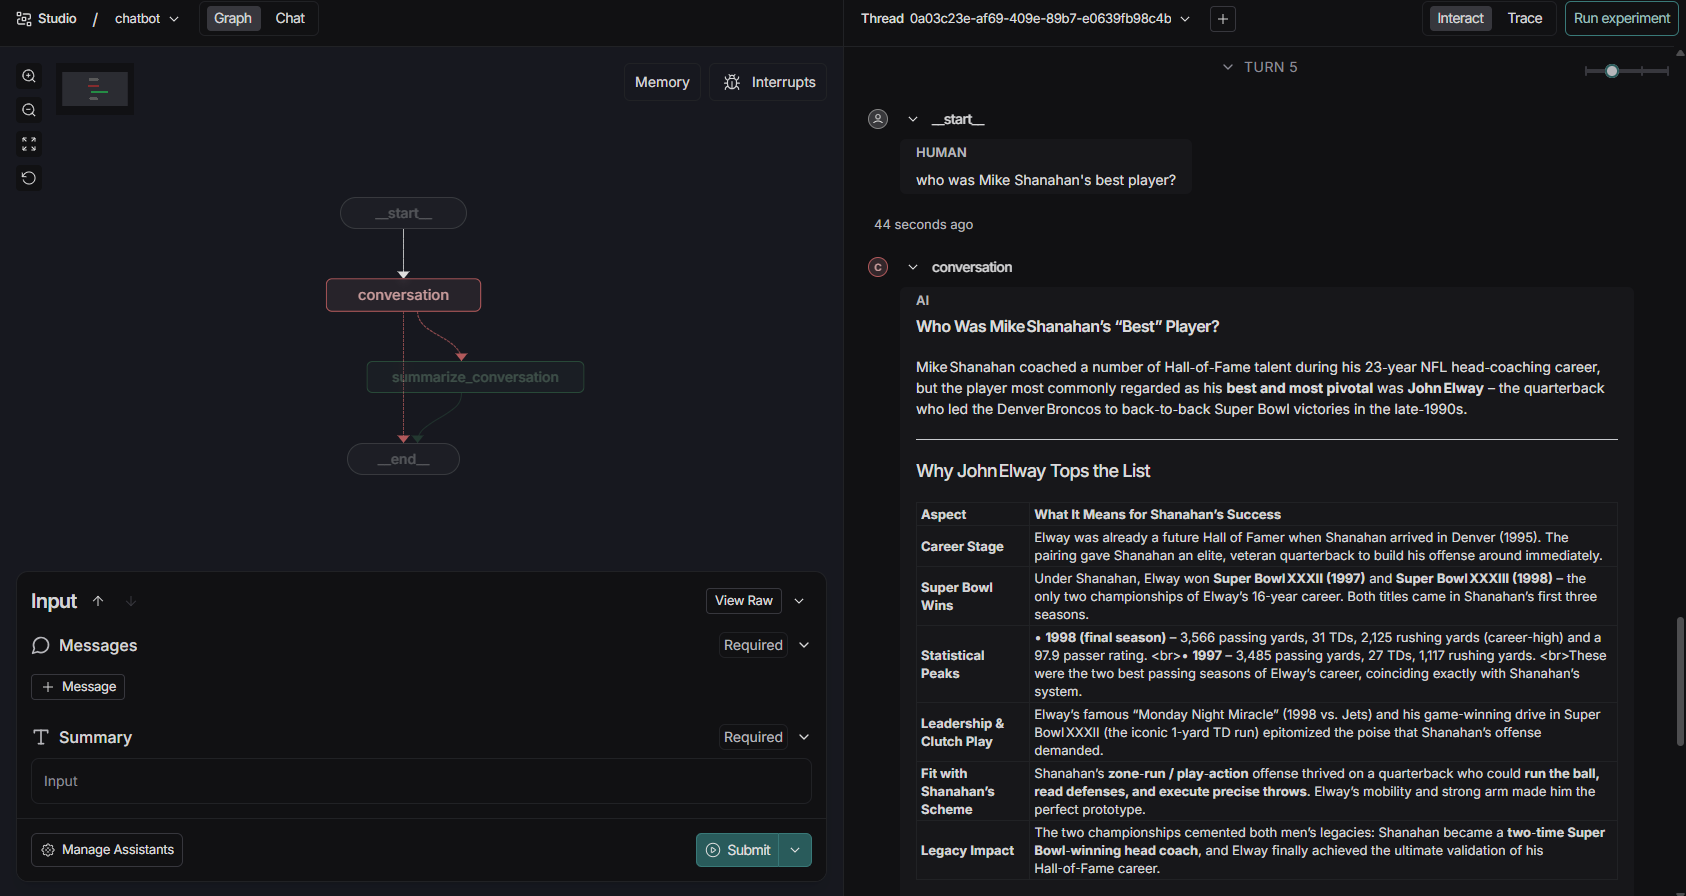

# MY EXAMPLES:

Here are 5 prompts about space exploration to test your chatbot's memory and summarization:

1.  **Prompt 1:** `Hi chatbot! I'm curious about space.`
2.  **Prompt 2:** `What is the largest planet in our solar system?`
3.  **Prompt 3:** `Tell me about Jupiter's Great Red Spot.`
4.  **Prompt 4:** `Are there any moons around Jupiter that might have liquid water?`
5.  **Prompt 5:** `Based on our chat, which moon of Jupiter did we discuss that might have liquid water?`

Initial prompt:

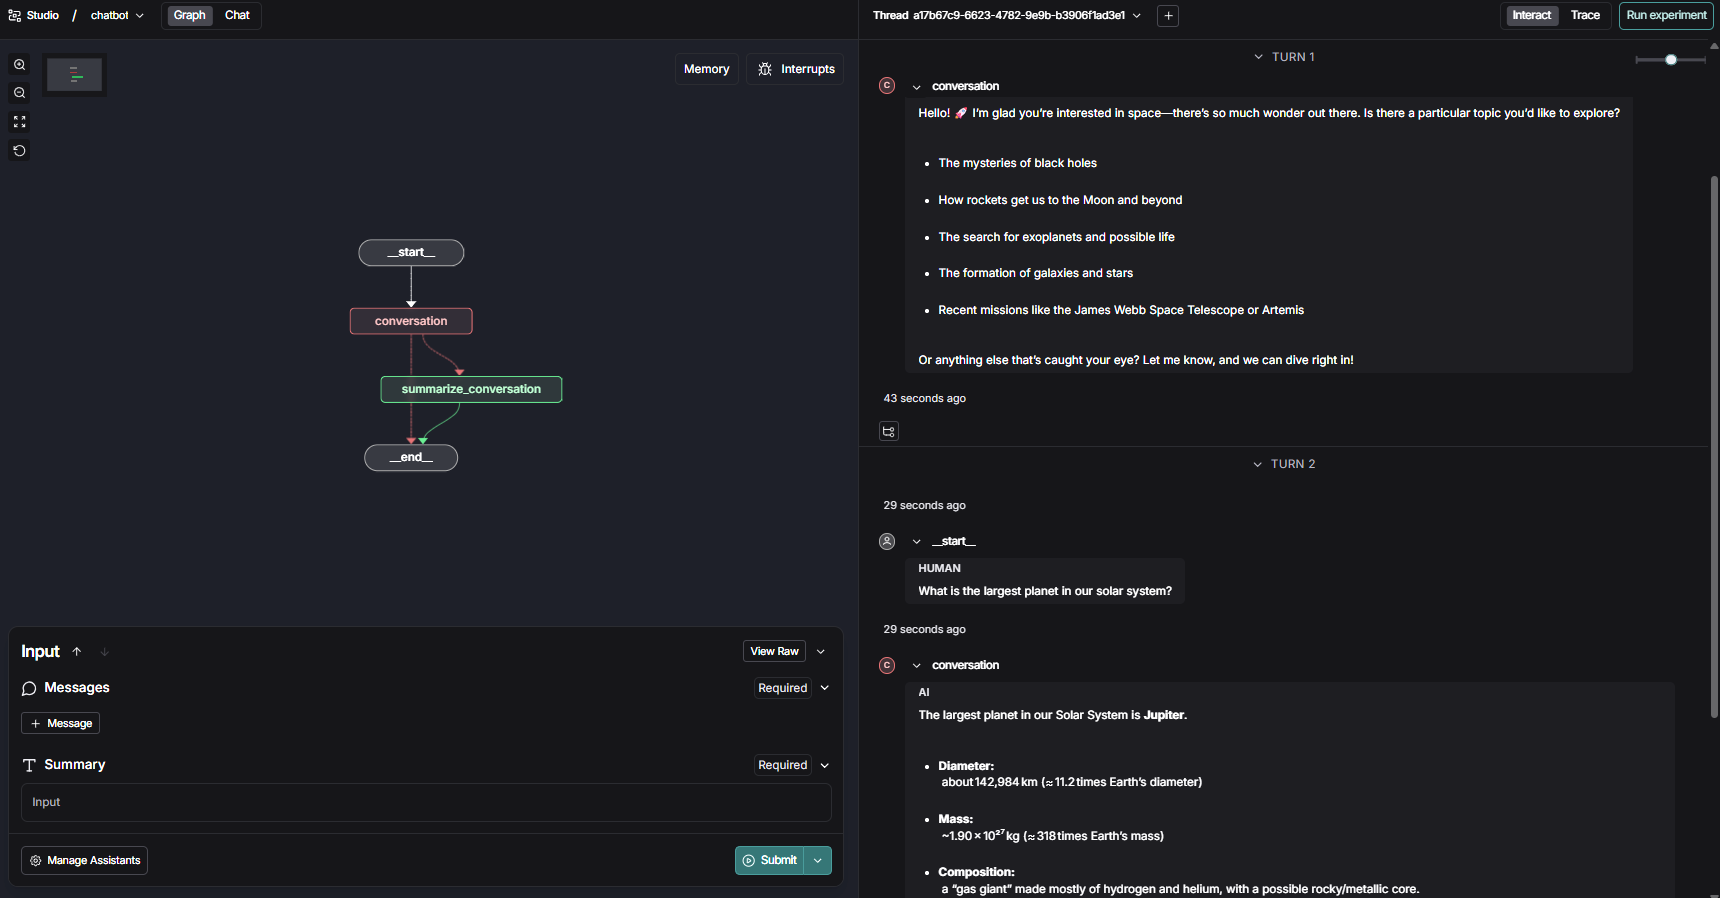

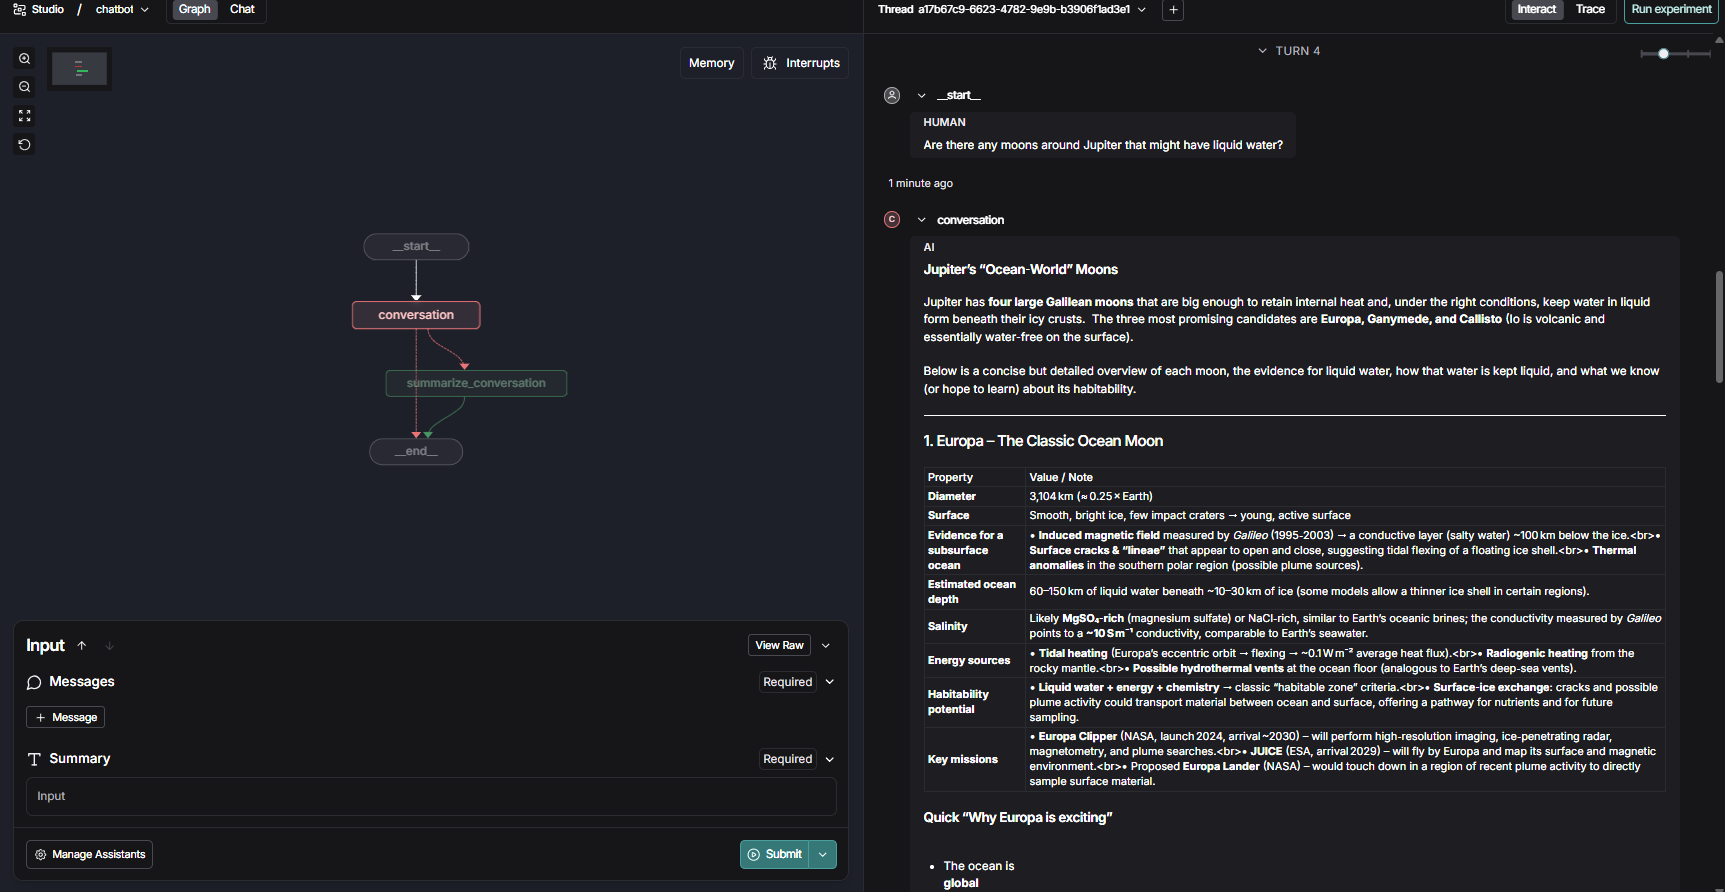

As you can see, after the 4th prompt, it hit the messages threshold limit and summarized. In the final prompt, it successfully remembered the initial outputs:

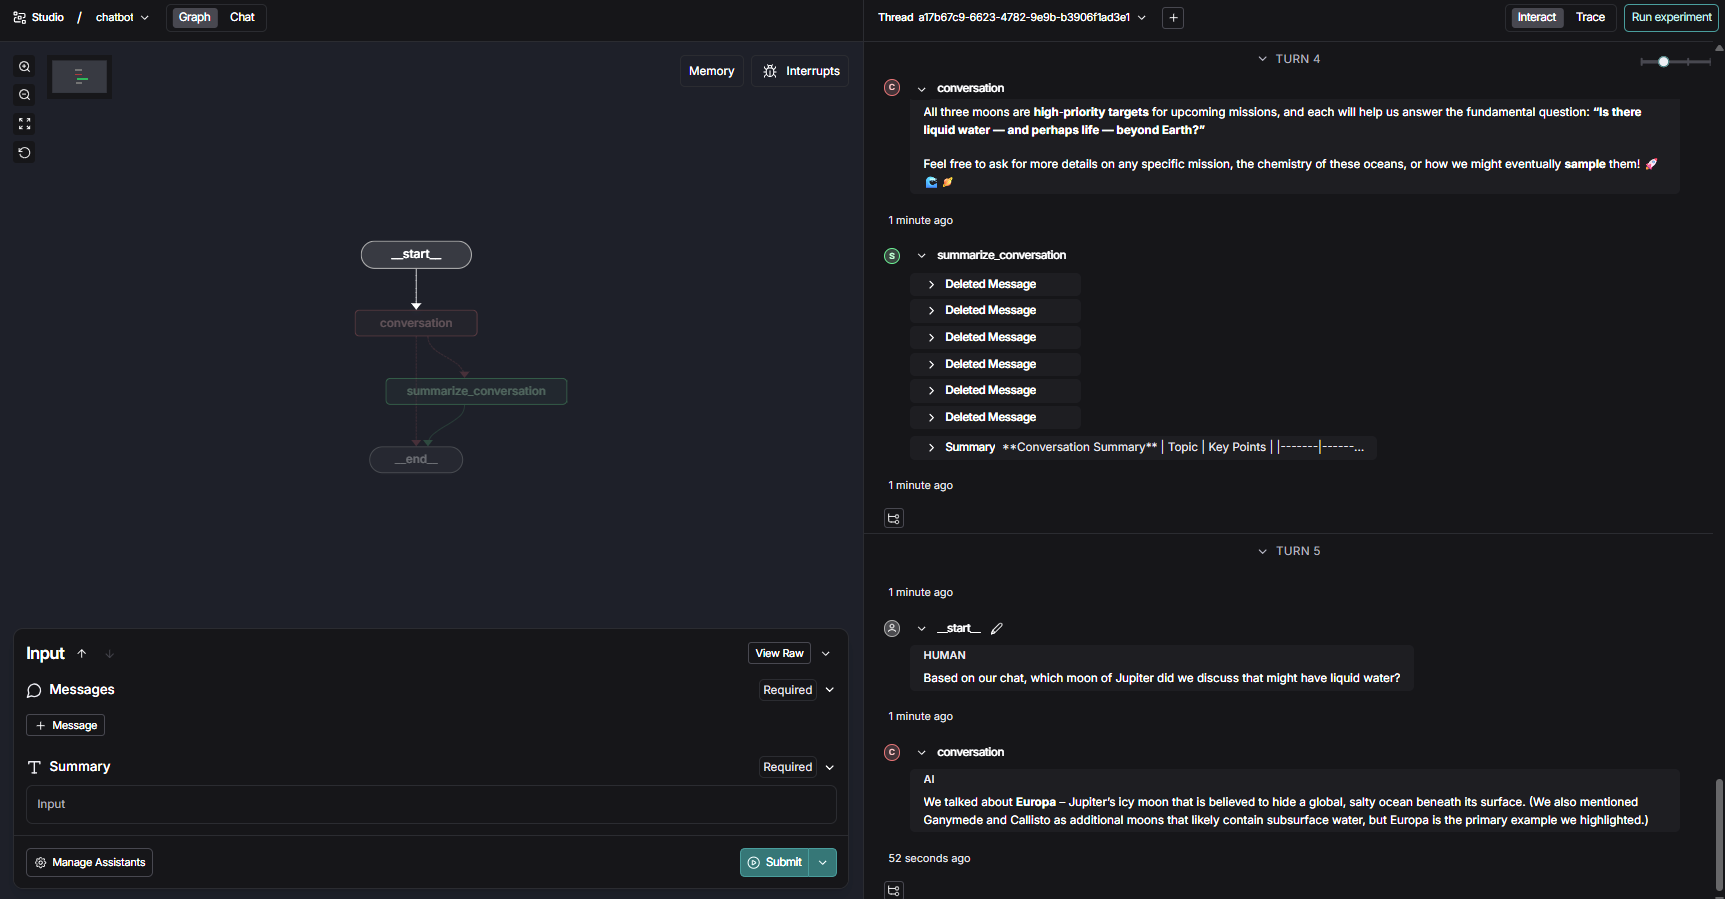